In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import dpdata
import glob
import seaborn as sns
import pandas as pd
import os

In [2]:
# load data
desc_string = 'descriptors/*/desc.npy'
dpdata_name = "FeCHO-clean-v2-7-20873"
dpdata_path = "./data-clean-v2-7-20873-npy"
dpdata_string = "O*"

In [3]:
# define used function
def extract_elements_array(data: dpdata.LabeledSystem) -> list:
    '''extract elements array from dpdata for draw t-SNE'''
    types = data.data['atom_types']
    names = data.data['atom_names']
    ele_array = [names[ind] for ind in types]
    return ele_array

# read descriptors/*/desc.npy data
print("Reading descriptor results...")
desc_keys = []
all_desc_stru = []
for f in glob.glob(desc_string):
    # extract dirname of desc.npy from descriptors/*
    directory, _ = os.path.split(f)
    _, keyname = os.path.split(directory)
    desc_keys.append(keyname)
    one_desc = np.load(f) # nframe, natoms, ndesc
    # do average in natoms dimension
    one_desc_stru = np.mean(one_desc, axis=1)
    all_desc_stru.append(one_desc_stru)
all_desc_stru = np.concatenate(all_desc_stru, axis=0)
np.shape(all_desc_stru)

Reading descriptor results...


(20873, 136)

In [4]:
# read dpdata for element type information 
#print("Reading corresponding dpdata...")
alldata =  dpdata.MultiSystems.from_dir(dpdata_path, dpdata_string, fmt="deepmd/npy")
alldata

MultiSystems (694 systems containing 20873 frames)

In [5]:
alldata_dict = {}
for lbsys in alldata:
    alldata_dict[lbsys.short_name] = lbsys

# get list of system name
sys_list = []
for keyname in desc_keys:
    target_sys = alldata_dict[keyname]
    for ind in range(target_sys.get_nframes()):
        sys_list.append(f"{keyname}-{ind}")
    
# get element ratio
element_ratio_dict = {}
element_names = alldata[0].get_atom_names()
for element in element_names:
    ratio_for_ele = []
    for keyname in desc_keys:
        target_sys = alldata_dict[keyname]
        ratio = target_sys.get_atom_numbs()[target_sys.get_atom_names().index(element)] / np.sum(target_sys.get_atom_numbs())
        ratio_for_ele.extend([ratio] * target_sys.get_nframes())
    element_ratio_dict[element] = ratio_for_ele

In [45]:
# 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim):
        """
        初始化残差块。
        :param hidden_dim: 隐藏层的维度
        """
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)  # 第一层全连接层
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # 第二层全连接层
        self.relu = nn.ReLU()  # 激活函数

    def forward(self, x):
        """
        前向传播。
        :param x: 输入数据
        :return: 输出数据
        """
        residual = x  # 保存输入作为残差
        out = self.relu(self.fc1(x))  # 通过第一层全连接层和激活函数
        out = self.fc2(out)  # 通过第二层全连接层
        out += residual  # 添加残差连接
        out = self.relu(out)  # 再次通过激活函数
        return out

# 定义带残差连接的目标网络和预测网络
class RNDNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        """
        初始化目标网络和预测网络的架构。
        :param input_dim: 输入数据的维度
        :param output_dim: 输出数据的维度
        :param hidden_dim: 隐藏层的维度, 默认为128
        """
        super(RNDNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # 第一层全连接层
        self.residual_block = ResidualBlock(hidden_dim)  # 残差块
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # 第二层全连接层
        self.relu = nn.ReLU()  # 激活函数

    def forward(self, x):
        """
        前向传播。
        :param x: 输入数据
        :return: 输出数据
        """
        x = self.fc1(x) # 通过第一层全连接层
        x = self.relu(x) # 通过激活函数
        x = self.residual_block(x)  # 通过残差块（包括激活函数）
        x = self.fc2(x)  # 通过第二层全连接层
        return x

In [51]:
# 定义RND模块
class RND:
    def __init__(self, input_dim, output_dim, distance_metric="mse", 
                 lr=1e-3, use_normalization=True):
        """
        初始化RND模块。
        :param input_dim: 输入数据的维度
        :param output_dim: 输出数据的维度
        :param distance_metric: 距离度量方案 ("mse", "kld", "cossim", "ce")
        :param lr: 学习率
        """
        self.target_network = RNDNetwork(input_dim, output_dim)  # 目标网络
        for param in self.target_network.parameters():
            param.requires_grad = False
            # 冻结目标网络的参数
        self.predictor_network = RNDNetwork(input_dim, output_dim)  # 预测网络
        self.optimizer = optim.Adam(self.predictor_network.parameters(), lr=lr)  # 优化器
        self.distance_metric = distance_metric  # 距离度量方案
        self.loss_fn = self._get_loss_fn(distance_metric)  # 损失函数
        # 是否开启动态归一化
        self.use_normalization = use_normalization
        # 奖励归一化参数，采用动态归一化方法
        self.intrinsic_reward_mean = 0.0  # 内在奖励的均值
        self.intrinsic_reward_std = 1.0  # 内在奖励的标准差
        self.intrinsic_reward_count = 0  # 内在奖励的计数
        
    def _update_reward_normalization(self, intrinsic_reward):
        """
        更新内在奖励的归一化参数。
        :param intrinsic_reward: 当前批次的内在奖励
        """
        self.intrinsic_reward_count += 1
        delta = intrinsic_reward - self.intrinsic_reward_mean
        self.intrinsic_reward_mean += delta / self.intrinsic_reward_count
        delta2 = intrinsic_reward - self.intrinsic_reward_mean
        self.intrinsic_reward_std += delta * delta2
        
    def _normalize_reward(self, intrinsic_reward):
        """
        归一化内在奖励。
        :param intrinsic_reward: 原始内在奖励
        :return: 归一化后的内在奖励
        """
        if self.use_normalization:
            # 更新归一化参数
            self._update_reward_normalization(intrinsic_reward)
            # 归一化奖励
            normalized_intrinsic_reward = (intrinsic_reward - self.intrinsic_reward_mean) / (self.intrinsic_reward_std + 1e-8)
            return normalized_intrinsic_reward
        else:
            # 不进行归一化，直接返回原始奖励
            return intrinsic_reward

    def _get_loss_fn(self, distance_metric):
        """
        根据距离度量方案选择损失函数。
        :param distance_metric: 距离度量方案
        :return: 对应的损失函数
        """
        if distance_metric == "kld":
            softmax = nn.Softmax(dim=-1)
            log_softmax = nn.LogSoftmax(dim=-1)
            kld_novelty_func = lambda target, pred: torch.sum(softmax(target) * (log_softmax(target) - log_softmax(pred)), dim=-1)
            return kld_novelty_func
        elif distance_metric == "mse":
            return nn.MSELoss(reduction='none')
        elif distance_metric == "cossim":
            return lambda target, pred: -(nn.CosineSimilarity(dim=-1)(target, pred) - 1)  # 修复维度问题
        elif distance_metric == "ce":
            softmax = nn.Softmax(dim=-1)
            log_softmax = nn.LogSoftmax(dim=-1)
            return lambda target, pred: -torch.sum(softmax(target) * log_softmax(pred), dim=-1)
        else:
            raise ValueError(f"Unknown distance metric: {distance_metric}")

    def get_intrinsic_reward(self, state):
        """
        计算内在奖励。
        :param state: 输入状态
        :return: 内在奖励值
        """
        state = torch.FloatTensor(state).unsqueeze(0)  # 将输入数据转换为张量并增加批次维度
        target_output = self.target_network(state).detach()  # 目标网络的输出
        predictor_output = self.predictor_network(state)  # 预测网络的输出
        if self.distance_metric == "mse":
            intrinsic_reward = torch.sum(self.loss_fn(predictor_output, target_output), dim=-1).item()
        else:
            intrinsic_reward = torch.mean(self.loss_fn(target_output, predictor_output)).item()
        # 返回归一化或原始奖励
        return self._normalize_reward(intrinsic_reward)

    def update_predictor(self, state):
        """
        更新预测网络。
        :param state: 输入状态
        :return: 当前批次的损失值
        """
        state = torch.FloatTensor(state).unsqueeze(0)  # 将输入数据转换为张量并增加批次维度
        target_output = self.target_network(state).detach()  # 目标网络的输出
        predictor_output = self.predictor_network(state)  # 预测网络的输出
        if self.distance_metric == "mse":
            loss = torch.mean(self.loss_fn(predictor_output, target_output))
        else:
            loss = torch.mean(self.loss_fn(target_output, predictor_output))
        self.optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        self.optimizer.step()  # 更新参数
        return loss.item()  # 返回当前批次的损失值

In [16]:
all_desc_stru_pt = torch.FloatTensor(all_desc_stru)
all_desc_stru_pt.shape

torch.Size([20873, 136])

In [38]:
import logging
import time
from torch.optim.lr_scheduler import ExponentialLR

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("rnd_training.log"),  # 输出到文件
        logging.StreamHandler()  # 输出到控制台
    ]
)


target_vector = all_desc_stru.copy()  

# 初始化 RND 模块
input_dim = 136  # 输入维度
output_dim = 136  # 输出维度（与输入维度相同）
hidden_dim = 240  # 隐藏层维度
rnd = RND(input_dim, output_dim, distance_metric="cossim")  # 使用 Cosine Similarity 作为距离度量

# RND 训练部分
train_data = target_vector.copy()  

# 初始化学习率调度器（指数下降）
initial_lr = 1e-3  # 初始学习率
gamma = 0.90  # 学习率下降系数
scheduler = ExponentialLR(rnd.optimizer, gamma=gamma)
loss_down_ratio = 0.1  # 每10%训练轮数后降低学习率

# 训练 RND 的预测网络
num_epochs = 200  # 训练轮数
batch_size = 2048  # 批量大小
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # 记录 epoch 开始时间
    epoch_loss = 0.0  # 记录当前 epoch 的总损失

    logging.info(f"Epoch {epoch + 1}/{num_epochs} started, learning rate: {scheduler.get_last_lr()[0]:.6f}")

    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]  # 获取当前批次数据
        batch_loss = rnd.update_predictor(batch)  # 更新预测网络并返回损失值
        epoch_loss += batch_loss  # 累加批次损失

    # 计算当前 epoch 的平均损失
    epoch_loss /= (len(train_data) / batch_size)
    epoch_time = time.time() - epoch_start_time  # 计算 epoch 耗时

    # 记录日志
    logging.info(f"Epoch {epoch + 1}/{num_epochs} completed, "
                 f"Time: {epoch_time:.2f}s, "
                 f"Loss: {epoch_loss:.6f}")

    # 更新学习率
    if epoch % (num_epochs * loss_down_ratio) == 0:
        scheduler.step()

# 计算每个点的独特性（内在奖励）
intrinsic_rewards = []
batch_size = 1024  # 批量计算以提高性能

# 批量计算内在奖励
for i in range(0, len(target_vector), batch_size):
    batch = target_vector[i:i + batch_size]  # 获取当前批次数据
    batch_rewards = [rnd.get_intrinsic_reward(state) for state in batch]  # 计算批次中每个点的内在奖励
    intrinsic_rewards.extend(batch_rewards)

# 将内在奖励转换为 numpy 数组
intrinsic_rewards = np.array(intrinsic_rewards)

# 找到前 100 个最独特的点
top_100_indices = np.argsort(intrinsic_rewards)[-100:]  # 获取奖励值最大的 100 个索引
top_100_points = target_vector[top_100_indices]  # 获取对应的点

# 输出结果
print("前 100 个最独特的点的索引：", top_100_indices)

2025-01-07 15:37:03,754 - INFO - Epoch 1/200 started, learning rate: 0.001000
2025-01-07 15:37:03,850 - INFO - Epoch 1/200 completed, Time: 0.10s, Loss: 0.565453
2025-01-07 15:37:03,851 - INFO - Epoch 2/200 started, learning rate: 0.000900
2025-01-07 15:37:03,943 - INFO - Epoch 2/200 completed, Time: 0.09s, Loss: 0.096647
2025-01-07 15:37:03,944 - INFO - Epoch 3/200 started, learning rate: 0.000900
2025-01-07 15:37:04,035 - INFO - Epoch 3/200 completed, Time: 0.09s, Loss: 0.046584
2025-01-07 15:37:04,036 - INFO - Epoch 4/200 started, learning rate: 0.000900
2025-01-07 15:37:04,129 - INFO - Epoch 4/200 completed, Time: 0.09s, Loss: 0.034897
2025-01-07 15:37:04,130 - INFO - Epoch 5/200 started, learning rate: 0.000900
2025-01-07 15:37:04,222 - INFO - Epoch 5/200 completed, Time: 0.09s, Loss: 0.027878
2025-01-07 15:37:04,223 - INFO - Epoch 6/200 started, learning rate: 0.000900
2025-01-07 15:37:04,314 - INFO - Epoch 6/200 completed, Time: 0.09s, Loss: 0.023715
2025-01-07 15:37:04,314 - IN

前 100 个最独特的点的索引： [  732 12956 12450 12973 15991 12975   723  1241 12974 15936 15904  9800
 13015 15981  6960   839  6724  7994   112 18328 12459 15948 19508 11455
 11466 11454 18840 17444  1235 15273 11438  6159 11192 13014 15910 15957
  3613  6722  4456 11437 15956  5772  5758 16561   113   111 15894 15908
 10825  7522 12952 18349  6816 11450  7519 13027  3556 11441  5740  5771
  5761 18848 20751 18301 18306  4210 18889  4108 20750  6720  4109   110
 19571 10367 18342 18307  3599 12469 13058 12464  1288  4474 12466 18294
  7520 10815 12960 10101 18807 18806  4221 18805 18101 15594 10805  4224
  4225 11636 12453  7382]


In [ ]:
# another try
import logging
import time
from torch.optim.lr_scheduler import ExponentialLR

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("rnd_training.log"),  # 输出到文件
        logging.StreamHandler()  # 输出到控制台
    ]
)

target_vector = all_desc_stru.copy()  

# 初始化 RND 模块
input_dim = 136  # 输入维度
output_dim = 136  # 输出维度（与输入维度相同）
hidden_dim = 240  # 隐藏层维度
rnd = RND(input_dim, output_dim, distance_metric="cossim")  # 使用 Cosine Similarity 作为距离度量

# RND 训练部分
train_data = target_vector.copy()  

# 初始化学习率调度器（指数下降）
initial_lr = 1e-3  # 初始学习率
gamma = 0.90  # 学习率下降系数
scheduler = ExponentialLR(rnd.optimizer, gamma=gamma)
loss_down_ratio = 0.1  # 每5%训练轮数后降低学习率

# 训练 RND 的预测网络
num_epochs = 100  # 训练轮数
batch_size = 4096  # 批量大小
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # 记录 epoch 开始时间
    epoch_loss = 0.0  # 记录当前 epoch 的总损失

    logging.info(f"Epoch {epoch + 1}/{num_epochs} started, learning rate: {scheduler.get_last_lr()[0]:.6f}")

    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]  # 获取当前批次数据
        batch_loss = rnd.update_predictor(batch)  # 更新预测网络并返回损失值
        epoch_loss += batch_loss  # 累加批次损失

    # 计算当前 epoch 的平均损失
    epoch_loss /= (len(train_data) / batch_size)
    epoch_time = time.time() - epoch_start_time  # 计算 epoch 耗时

    # 记录日志
    logging.info(f"Epoch {epoch + 1}/{num_epochs} completed, "
                 f"Time: {epoch_time:.2f}s, "
                 f"Loss: {epoch_loss:.6f}")

    # 更新学习率
    if epoch % (num_epochs * loss_down_ratio) == 0:
        scheduler.step()

# 计算每个点的独特性（内在奖励）
intrinsic_rewards = []
batch_size = 1024  # 批量计算以提高性能

# 批量计算内在奖励
for i in range(0, len(target_vector), batch_size):
    batch = target_vector[i:i + batch_size]  # 获取当前批次数据
    batch_rewards = [rnd.get_intrinsic_reward(state) for state in batch]  # 计算批次中每个点的内在奖励
    intrinsic_rewards.extend(batch_rewards)

# 将内在奖励转换为 numpy 数组
intrinsic_rewards = np.array(intrinsic_rewards)

# 找到前 100 个最独特的点
top_100_indices = np.argsort(intrinsic_rewards)[-100:]  # 获取奖励值最大的 100 个索引
top_100_points = target_vector[top_100_indices]  # 获取对应的点

# 输出结果
print("前 100 个最独特的点的索引：", top_100_indices)

2025-01-07 15:47:19,032 - INFO - Epoch 1/1000 started, learning rate: 0.001000


2025-01-07 15:47:19,121 - INFO - Epoch 1/1000 completed, Time: 0.09s, Loss: 0.822129
2025-01-07 15:47:19,122 - INFO - Epoch 2/1000 started, learning rate: 0.000900
2025-01-07 15:47:19,206 - INFO - Epoch 2/1000 completed, Time: 0.08s, Loss: 0.279478
2025-01-07 15:47:19,207 - INFO - Epoch 3/1000 started, learning rate: 0.000900
2025-01-07 15:47:19,285 - INFO - Epoch 3/1000 completed, Time: 0.08s, Loss: 0.102323
2025-01-07 15:47:19,286 - INFO - Epoch 4/1000 started, learning rate: 0.000900
2025-01-07 15:47:19,362 - INFO - Epoch 4/1000 completed, Time: 0.08s, Loss: 0.054353
2025-01-07 15:47:19,363 - INFO - Epoch 5/1000 started, learning rate: 0.000900
2025-01-07 15:47:19,439 - INFO - Epoch 5/1000 completed, Time: 0.08s, Loss: 0.039018
2025-01-07 15:47:19,440 - INFO - Epoch 6/1000 started, learning rate: 0.000900
2025-01-07 15:47:19,513 - INFO - Epoch 6/1000 completed, Time: 0.07s, Loss: 0.032202
2025-01-07 15:47:19,514 - INFO - Epoch 7/1000 started, learning rate: 0.000900
2025-01-07 15:47

前 100 个最独特的点的索引： [12976  1241 13837 13027 15227 15228 10331 13839  3613 12465  1182 16561
  7986 13014 15948 19138 19088  7526 19494 12974  7524 19571 13020 10319
 12973 19204 19203   111  7523 16021  4210 12975  6724  7384  3556  8054
  7675  3449  8019 13015 18830 15594 10815  7528   731  4221  4223 18334
 14751 10347 18294 10320 15271  7525 15272  7520  2097 12967 15894 15908
 11459   723 19596  7969  6749  4474 12469 12464 12952   110 12466 18326
 18848 18889 15273   734 18840  4225 10367  4224  6060 13058 12960 18101
   732  4108  4109  3599 10805 18807 18806 18805 17444 12453 18307 18342
  1288 11636 10101  7382]


In [46]:
# another try
import logging
import time
from torch.optim.lr_scheduler import ExponentialLR

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("rnd_training.log"),  # 输出到文件
        logging.StreamHandler()  # 输出到控制台
    ]
)

target_vector = all_desc_stru.copy()  

# 初始化 RND 模块
input_dim = 136  # 输入维度
output_dim = 136  # 输出维度（与输入维度相同）
hidden_dim = 240  # 隐藏层维度
rnd = RND(input_dim, output_dim, distance_metric="cossim")  # 使用 Cosine Similarity 作为距离度量

# RND 训练部分
train_data = target_vector.copy()  

# 初始化学习率调度器（指数下降）
initial_lr = 1e-3  # 初始学习率
gamma = 0.90  # 学习率下降系数
scheduler = ExponentialLR(rnd.optimizer, gamma=gamma)
loss_down_ratio = 0.1  # 每10%训练轮数后降低学习率

# 训练 RND 的预测网络
num_epochs = 200  # 训练轮数
batch_size = 4096  # 批量大小
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # 记录 epoch 开始时间
    epoch_loss = 0.0  # 记录当前 epoch 的总损失

    logging.info(f"Epoch {epoch + 1}/{num_epochs} started, learning rate: {scheduler.get_last_lr()[0]:.6f}")

    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]  # 获取当前批次数据
        batch_loss = rnd.update_predictor(batch)  # 更新预测网络并返回损失值
        epoch_loss += batch_loss  # 累加批次损失

    # 计算当前 epoch 的平均损失
    epoch_loss /= (len(train_data) / batch_size)
    epoch_time = time.time() - epoch_start_time  # 计算 epoch 耗时

    # 记录日志
    logging.info(f"Epoch {epoch + 1}/{num_epochs} completed, "
                 f"Time: {epoch_time:.2f}s, "
                 f"Loss: {epoch_loss:.6f}")

    # 更新学习率
    if epoch % (num_epochs * loss_down_ratio) == 0:
        scheduler.step()

# 计算每个点的独特性（内在奖励）
intrinsic_rewards = []
batch_size = 1024  # 批量计算以提高性能

# 批量计算内在奖励
for i in range(0, len(target_vector), batch_size):
    batch = target_vector[i:i + batch_size]  # 获取当前批次数据
    batch_rewards = [rnd.get_intrinsic_reward(state) for state in batch]  # 计算批次中每个点的内在奖励
    intrinsic_rewards.extend(batch_rewards)

# 将内在奖励转换为 numpy 数组
intrinsic_rewards = np.array(intrinsic_rewards)

# 找到前 100 个最独特的点
top_100_indices = np.argsort(intrinsic_rewards)[-100:]  # 获取奖励值最大的 100 个索引
top_100_points = target_vector[top_100_indices]  # 获取对应的点

# 输出结果
print("前 100 个最独特的点的索引：", top_100_indices)

2025-01-07 16:09:17,769 - INFO - Epoch 1/200 started, learning rate: 0.001000
2025-01-07 16:09:17,834 - INFO - Epoch 1/200 completed, Time: 0.06s, Loss: 0.723848
2025-01-07 16:09:17,835 - INFO - Epoch 2/200 started, learning rate: 0.000900
2025-01-07 16:09:17,902 - INFO - Epoch 2/200 completed, Time: 0.07s, Loss: 0.378483
2025-01-07 16:09:17,903 - INFO - Epoch 3/200 started, learning rate: 0.000900
2025-01-07 16:09:17,969 - INFO - Epoch 3/200 completed, Time: 0.07s, Loss: 0.196277
2025-01-07 16:09:17,970 - INFO - Epoch 4/200 started, learning rate: 0.000900
2025-01-07 16:09:18,029 - INFO - Epoch 4/200 completed, Time: 0.06s, Loss: 0.115266
2025-01-07 16:09:18,029 - INFO - Epoch 5/200 started, learning rate: 0.000900
2025-01-07 16:09:18,086 - INFO - Epoch 5/200 completed, Time: 0.06s, Loss: 0.077116
2025-01-07 16:09:18,087 - INFO - Epoch 6/200 started, learning rate: 0.000900
2025-01-07 16:09:18,140 - INFO - Epoch 6/200 completed, Time: 0.05s, Loss: 0.056201
2025-01-07 16:09:18,141 - IN

前 100 个最独特的点的索引： [19305 12973  2097  3613 12975 20750  4415 12974 15995  4401  1182  4408
 18889  4409  4411 11459 19596 15899 11454 11455 11466 18328 15966  4417
  3449 11438 18349  4418 18301 18306 15906 11437  4210  4108 15963   110
 16004 15939 15971 10367 16561 17444  6060 15948 12952  4416  4109 15936
 15904 15981  7521 18848  3599  4223  4413  6166  6749 11450 11441  6173
 18840  5769 15957 15910  5759  5738  5722  5739 18294 12960  1288 10101
 13020 12469 12464 18342  4474 12466 13058 18307  7520 15594  4221 15273
 18101 11636  6159 18805 18807 18806  5758  5772 10815  7522 10805  7519
  4224  4225  7382 12453]


In [64]:
# another try 01071943 1-200 2-500
import logging
import time
from torch.optim.lr_scheduler import ExponentialLR

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("rnd_training.log"),  # 输出到文件
        logging.StreamHandler()  # 输出到控制台
    ]
)


target_vector = all_desc_stru.copy()  

# 初始化 RND 模块
input_dim = 136  # 输入维度
output_dim = 136  # 输出维度（与输入维度相同）
hidden_dim = 240  # 隐藏层维度
rnd = RND(input_dim, output_dim, distance_metric="cossim")  # 使用 Cosine Similarity 作为距离度量

# RND 训练部分
train_data = target_vector.copy()  

# 初始化学习率调度器（指数下降）
initial_lr = 1e-3  # 初始学习率
gamma = 0.90  # 学习率下降系数
scheduler = ExponentialLR(rnd.optimizer, gamma=gamma)
loss_down_ratio = 0.05  # 每2%训练轮数后降低学习率

# 训练 RND 的预测网络
num_epochs = 500  # 训练轮数
batch_size = 4096  # 批量大小
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # 记录 epoch 开始时间
    epoch_loss = 0.0  # 记录当前 epoch 的总损失

    logging.info(f"Epoch {epoch + 1}/{num_epochs} started, learning rate: {scheduler.get_last_lr()[0]:.6f}")

    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]  # 获取当前批次数据
        batch_loss = rnd.update_predictor(batch)  # 更新预测网络并返回损失值
        epoch_loss += batch_loss  # 累加批次损失

    # 计算当前 epoch 的平均损失
    epoch_loss /= (len(train_data) / batch_size)
    epoch_time = time.time() - epoch_start_time  # 计算 epoch 耗时

    # 记录日志
    logging.info(f"Epoch {epoch + 1}/{num_epochs} completed, "
                 f"Time: {epoch_time:.2f}s, "
                 f"Loss: {epoch_loss:.6f}")

    # 更新学习率
    if epoch % (num_epochs * loss_down_ratio) == 0:
        scheduler.step()

# 计算每个点的独特性（内在奖励）
intrinsic_rewards = []
batch_size = 1024  # 批量计算以提高性能

# 批量计算内在奖励
for i in range(0, len(target_vector), batch_size):
    batch = target_vector[i:i + batch_size]  # 获取当前批次数据
    batch_rewards = [rnd.get_intrinsic_reward(state) for state in batch]  # 计算批次中每个点的内在奖励
    intrinsic_rewards.extend(batch_rewards)

# 将内在奖励转换为 numpy 数组
intrinsic_rewards = np.array(intrinsic_rewards)

# 找到前 100 个最独特的点
top_100_indices = np.argsort(intrinsic_rewards)[-100:]  # 获取奖励值最大的 100 个索引
top_100_points = target_vector[top_100_indices]  # 获取对应的点

# 输出结果
print("前 100 个最独特的点的索引：", top_100_indices)

2025-01-07 20:02:39,377 - INFO - Epoch 1/500 started, learning rate: 0.001000
2025-01-07 20:02:39,443 - INFO - Epoch 1/500 completed, Time: 0.07s, Loss: 0.556646
2025-01-07 20:02:39,444 - INFO - Epoch 2/500 started, learning rate: 0.000900
2025-01-07 20:02:39,512 - INFO - Epoch 2/500 completed, Time: 0.07s, Loss: 0.226664
2025-01-07 20:02:39,513 - INFO - Epoch 3/500 started, learning rate: 0.000900
2025-01-07 20:02:39,568 - INFO - Epoch 3/500 completed, Time: 0.06s, Loss: 0.115203
2025-01-07 20:02:39,569 - INFO - Epoch 4/500 started, learning rate: 0.000900
2025-01-07 20:02:39,629 - INFO - Epoch 4/500 completed, Time: 0.06s, Loss: 0.069863
2025-01-07 20:02:39,630 - INFO - Epoch 5/500 started, learning rate: 0.000900
2025-01-07 20:02:39,688 - INFO - Epoch 5/500 completed, Time: 0.06s, Loss: 0.047852
2025-01-07 20:02:39,689 - INFO - Epoch 6/500 started, learning rate: 0.000900
2025-01-07 20:02:39,749 - INFO - Epoch 6/500 completed, Time: 0.06s, Loss: 0.036319
2025-01-07 20:02:39,750 - IN

前 100 个最独特的点的索引： [15901 15939  9800 12459 13838  6060  7525  6723   732  8962  5198 19916
 19945 15956 19088 11192 10828  6749 15936  7523 15904 16561 12975  2097
 15981  7986 12973  3421 11459 12974 15228 15227 12465 15894  6722 15908
  6740 10825 16049   731 15957 15910 10320 10319  8067 18326 13027 15948
 13015   723  6720 13058   110  6724 18307 12952 18840  6159 13014  5771
  5740  5758  5761 18294  5772  3613 18889 17444  4210 18848 12960  4108
  7522 13020 10367 11636  4109  4474 18342 12469  7519  3599  7520 15273
 12464  1288 10805 18806 18807 18805 12466 15594 10815  4221  7382 18101
  4224  4225 10101 12453]


In [28]:
intrinsic_rewards.shape

(20873,)

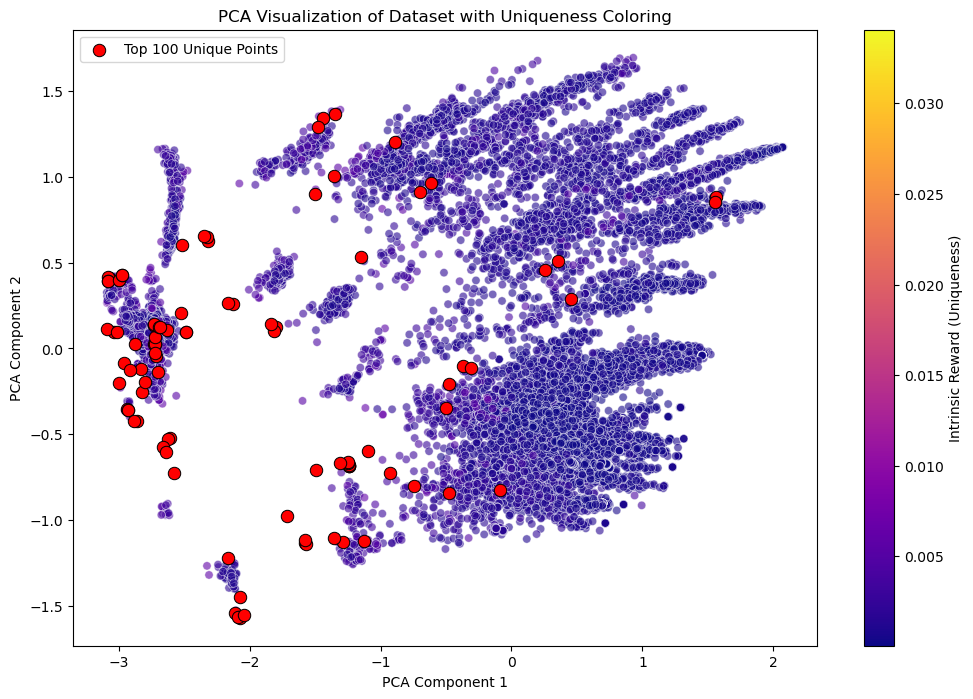

In [39]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# PCA 可视化部分
# 使用 PCA 将数据降维到 2D
pca = PCA(n_components=2)  # 降维到 2D
pca_result = pca.fit_transform(target_vector)  # 对整个数据集进行 PCA 降维
top_100_pca_result = pca.transform(top_100_points)  # 对前 100 个最独特的点进行 PCA 降维

# 可视化
plt.figure(figsize=(12, 8))

# 绘制所有点，颜色表示独特性度量
ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

# 绘制前 100 个最独特的点，用红色标注
sns.scatterplot(
    x=top_100_pca_result[:, 0], y=top_100_pca_result[:, 1],
    color="red", label="Top 100 Unique Points", s=80, edgecolor="black"
)

# 添加颜色条
norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

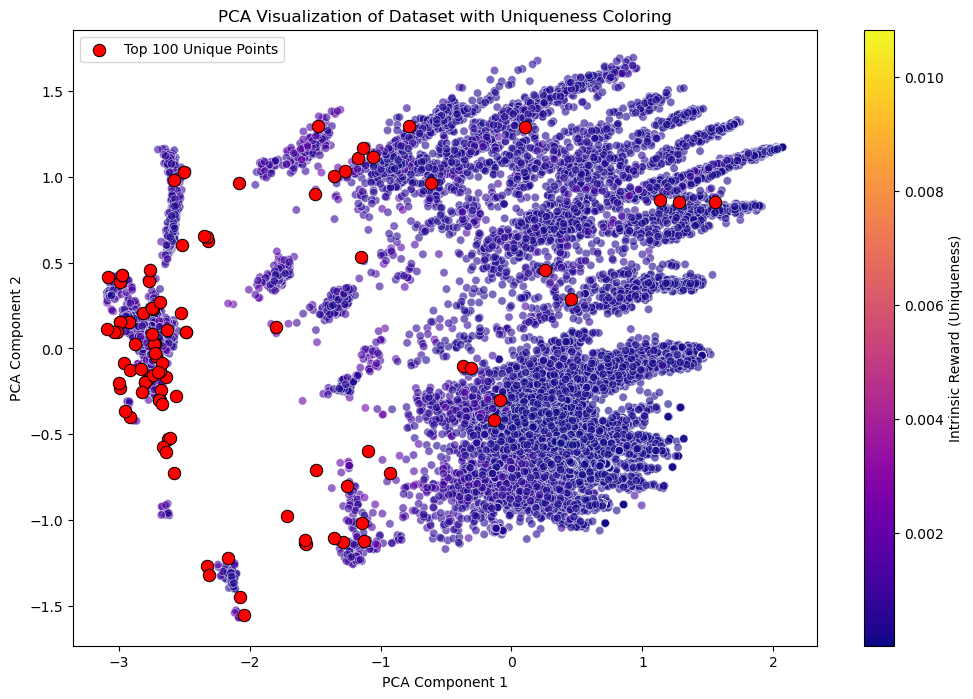

In [43]:
# in another try
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# PCA 可视化部分
# 使用 PCA 将数据降维到 2D
pca = PCA(n_components=2)  # 降维到 2D
pca_result = pca.fit_transform(target_vector)  # 对整个数据集进行 PCA 降维
top_100_pca_result = pca.transform(top_100_points)  # 对前 100 个最独特的点进行 PCA 降维

# 可视化
plt.figure(figsize=(12, 8))

# 绘制所有点，颜色表示独特性度量
ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

# 绘制前 100 个最独特的点，用红色标注
sns.scatterplot(
    x=top_100_pca_result[:, 0], y=top_100_pca_result[:, 1],
    color="red", label="Top 100 Unique Points", s=80, edgecolor="black"
)

# 添加颜色条
norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

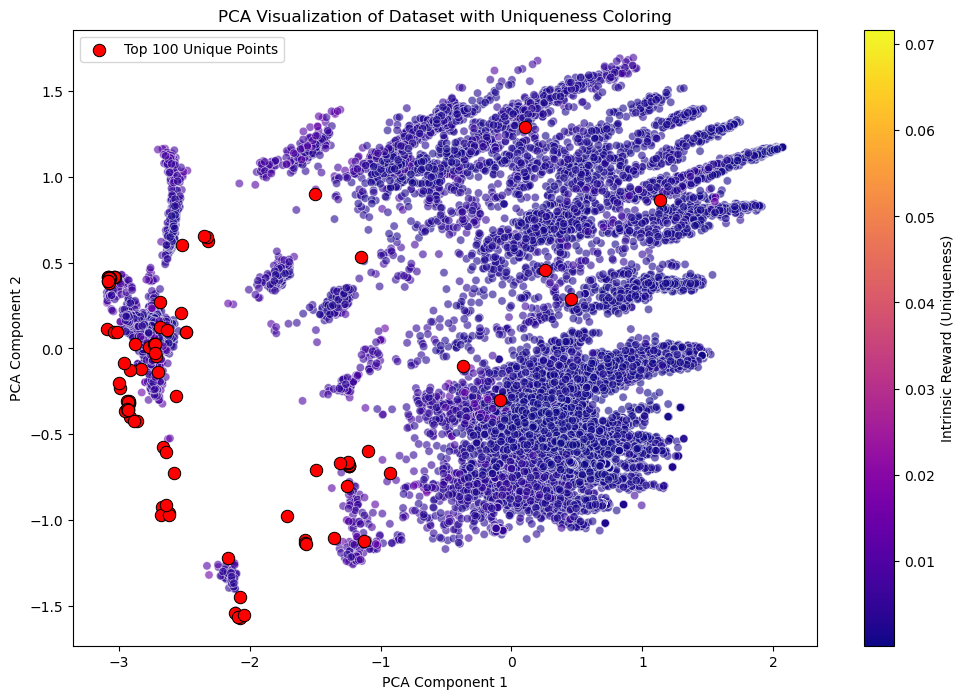

In [47]:
# in another try
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# PCA 可视化部分
# 使用 PCA 将数据降维到 2D
pca = PCA(n_components=2)  # 降维到 2D
pca_result = pca.fit_transform(target_vector)  # 对整个数据集进行 PCA 降维
top_100_pca_result = pca.transform(top_100_points)  # 对前 100 个最独特的点进行 PCA 降维

# 可视化
plt.figure(figsize=(12, 8))

# 绘制所有点，颜色表示独特性度量
ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

# 绘制前 100 个最独特的点，用红色标注
sns.scatterplot(
    x=top_100_pca_result[:, 0], y=top_100_pca_result[:, 1],
    color="red", label="Top 100 Unique Points", s=80, edgecolor="black"
)

# 添加颜色条
norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

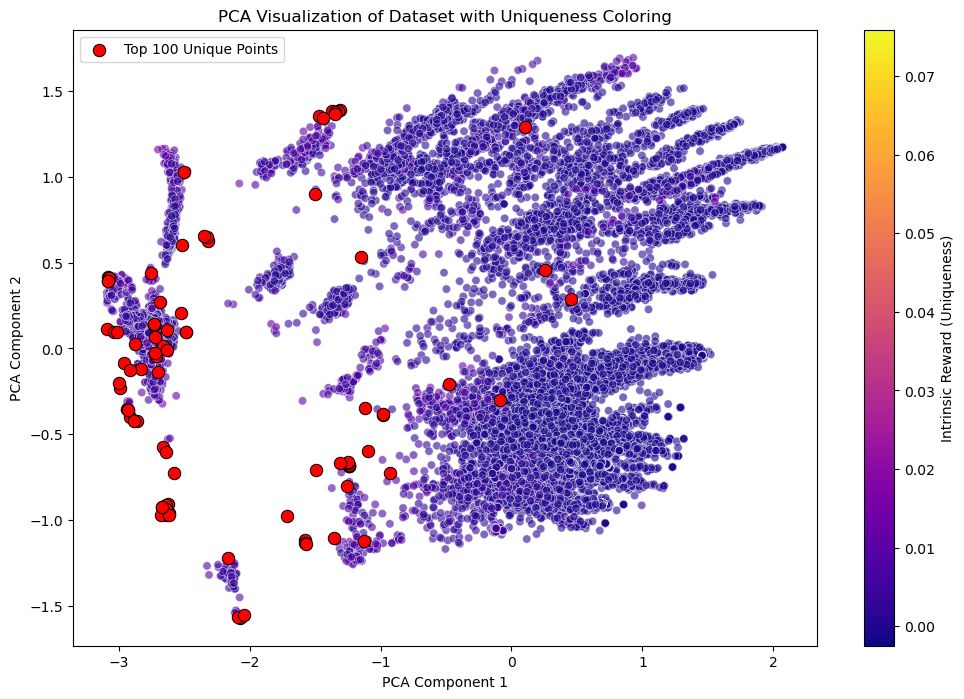

In [61]:
# in another try 20251955
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA 可视化部分
# 使用 PCA 将数据降维到 2D
pca = PCA(n_components=2)  # 降维到 2D
pca_result = pca.fit_transform(target_vector)  # 对整个数据集进行 PCA 降维
top_100_pca_result = pca.transform(top_100_points)  # 对前 100 个最独特的点进行 PCA 降维

# 可视化
plt.figure(figsize=(12, 8))

# 绘制所有点，颜色表示独特性度量
ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

# 绘制前 100 个最独特的点，用红色标注
sns.scatterplot(
    x=top_100_pca_result[:, 0], y=top_100_pca_result[:, 1],
    color="red", label="Top 100 Unique Points", s=80, edgecolor="black"
)

# 添加颜色条
norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

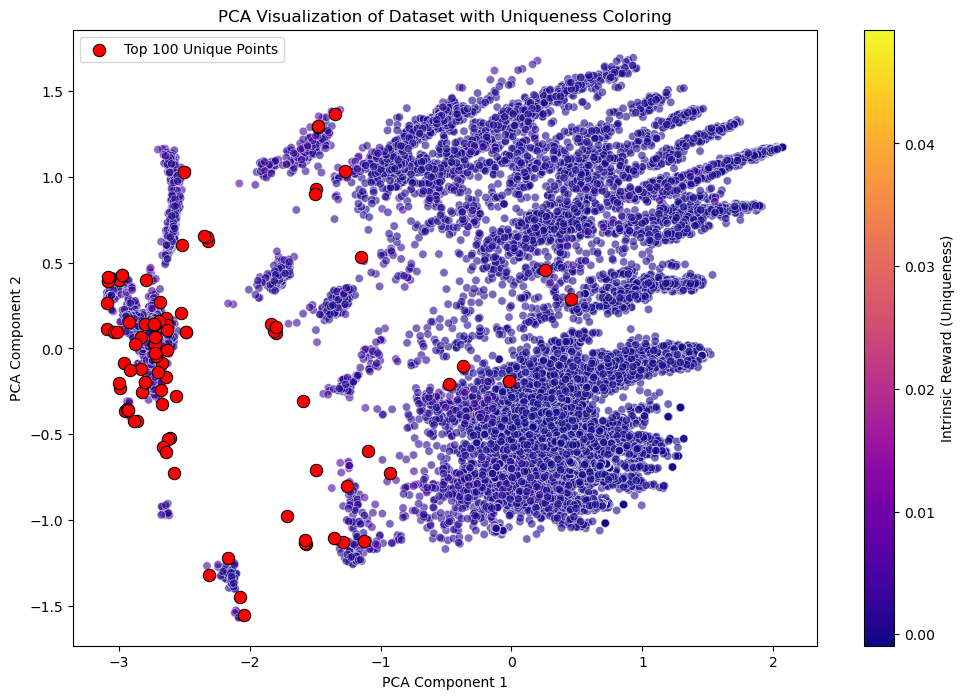

In [65]:
# in another try 20251955-2
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA 可视化部分
# 使用 PCA 将数据降维到 2D
pca = PCA(n_components=2)  # 降维到 2D
pca_result = pca.fit_transform(target_vector)  # 对整个数据集进行 PCA 降维
top_100_pca_result = pca.transform(top_100_points)  # 对前 100 个最独特的点进行 PCA 降维

# 可视化
plt.figure(figsize=(12, 8))

# 绘制所有点，颜色表示独特性度量
ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

# 绘制前 100 个最独特的点，用红色标注
sns.scatterplot(
    x=top_100_pca_result[:, 0], y=top_100_pca_result[:, 1],
    color="red", label="Top 100 Unique Points", s=80, edgecolor="black"
)

# 添加颜色条
norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

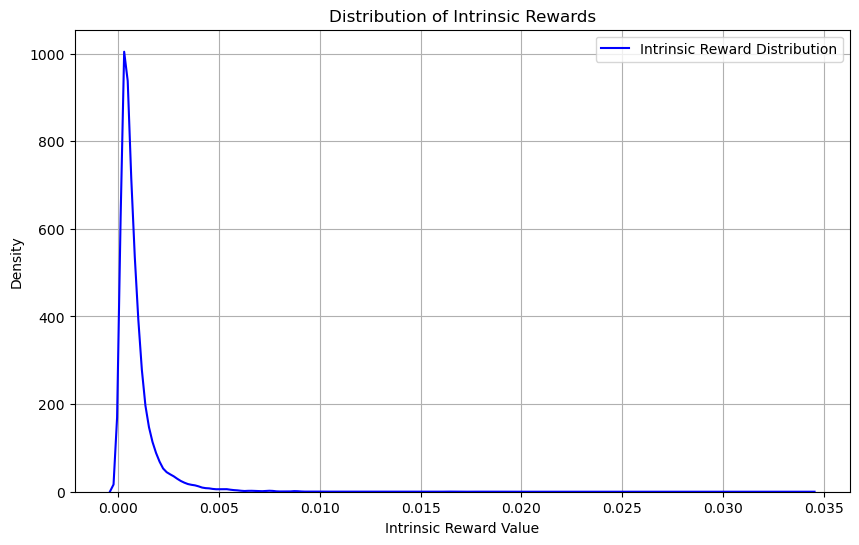

In [40]:
# 假设 intrinsic_rewards 是一个包含所有点内在奖励值的 numpy 数组
# intrinsic_rewards = np.random.rand(20873)  # 这里用随机数据代替，实际使用时替换为你的数据

# 绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

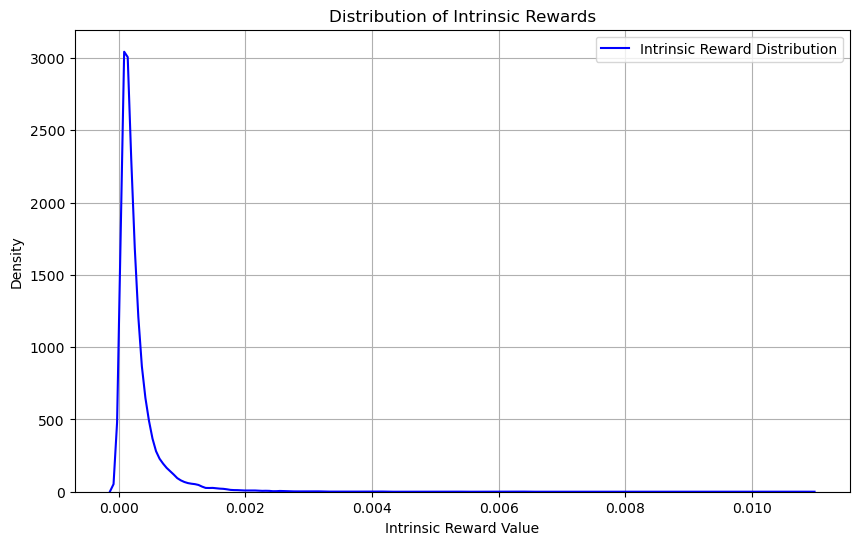

In [44]:
# in another try
# intrinsic_rewards = np.random.rand(20873)  # 这里用随机数据代替，实际使用时替换为你的数据

# 绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

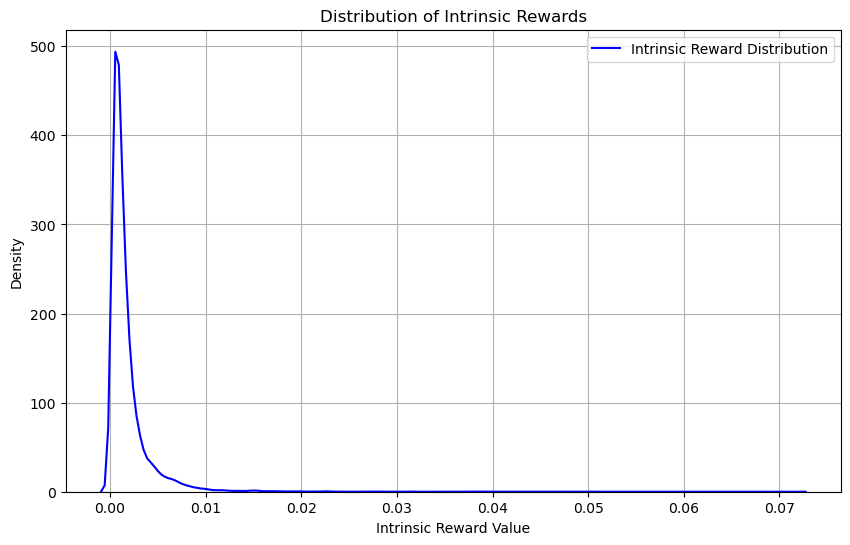

In [48]:
# in another try
# intrinsic_rewards = np.random.rand(20873)  # 这里用随机数据代替，实际使用时替换为你的数据

# 绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

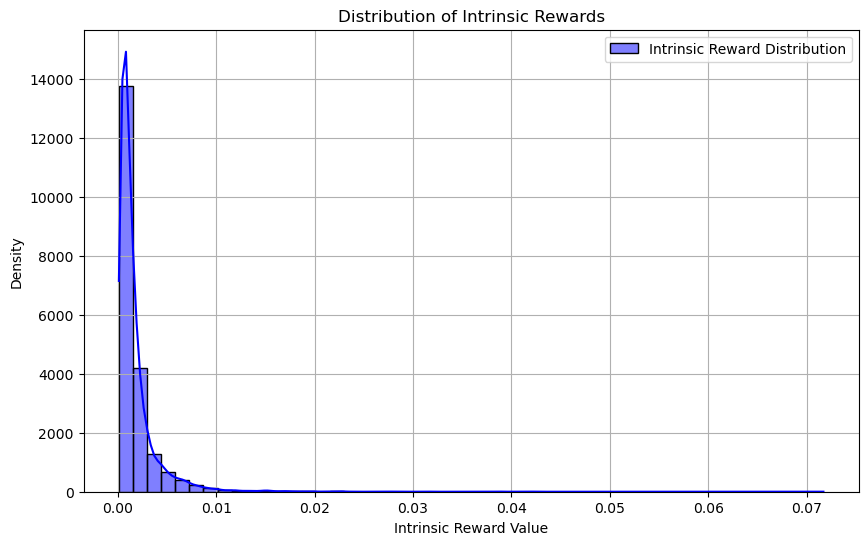

In [49]:
# 直接按照出现频率绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
#sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=50, kde=True)
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

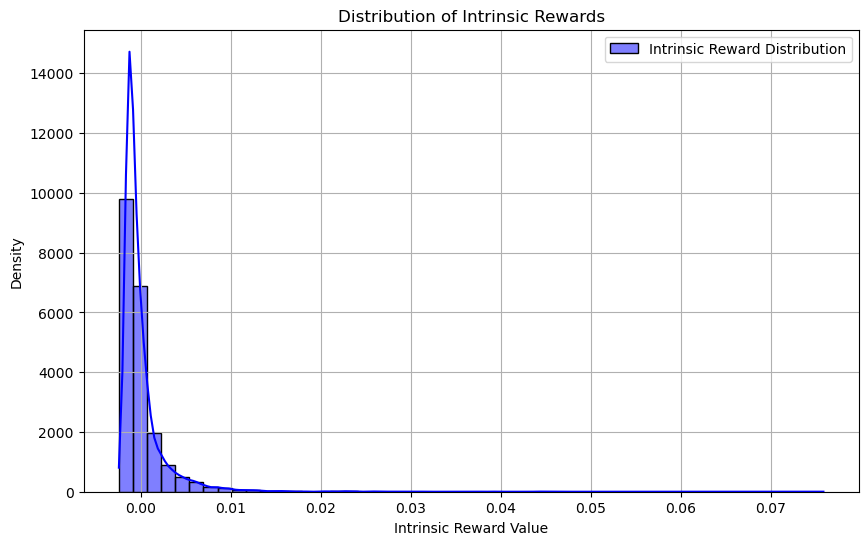

In [62]:
# another try 01072000
plt.figure(figsize=(10, 6))
#sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=50, kde=True)
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

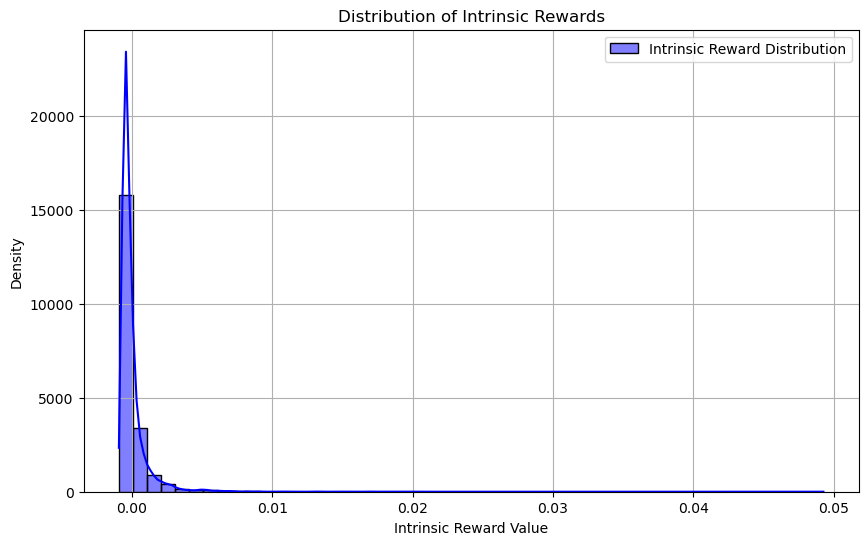

In [66]:
# another try 01072000
plt.figure(figsize=(10, 6))
#sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=50, kde=True)
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()